In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, default_data_collator
from torch.utils.data import DataLoader, TensorDataset
from transformers import Trainer, TrainingArguments, DistilBertConfig
from src.bert_preparation import prepare_bert_dataset, prepare_bert_dataset_with_er
from src.bert_model import train_bert_model, get_trainer, DistilBertWithER, compute_metrics,  BERTDatasetWithER

/home/onyxia/work/NLP-Sentiment-Classification/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("✅ CUDA disponible :", torch.cuda.is_available())
if torch.cuda.is_available():
    print("✅ Nom du GPU :", torch.cuda.get_device_name(0))
    print("✅ Nombre de GPUs :", torch.cuda.device_count())
else:
    print("❌ Aucun GPU détecté")

✅ CUDA disponible : True
✅ Nom du GPU : NVIDIA A2
✅ Nombre de GPUs : 1


In [3]:
# Charger le dataset, 12000 pos + 12000 neg
dataset = prepare_bert_dataset(sample_size=12000)
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 19200
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 4800
    })
})

In [4]:

#Fine-tuning DistilBERT
trainer = train_bert_model(dataset)
"""

trainer = get_trainer(dataset)
trainer.train(resume_from_checkpoint="results/checkpoint-1200")
"""

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.324700,0.256663,0.903542,0.905026,0.882753,0.928451
2,0.156100,0.254788,0.910000,0.909244,0.907718,0.910774


'\n\ntrainer = get_trainer(dataset)\ntrainer.train(resume_from_checkpoint="results/checkpoint-1200")\n'

Le modèle est entraîné sur deux époques seulement. On observe une baisse régulière du Training Loss, passant de 0.32 à 0.16, ce qui traduit un bon apprentissage sans difficulté de convergence. En parallèle, la Validation Loss diminue elle aussi, passant de 0.276 à 0.256, ce qui est encourageant et montre que le modèle généralise correctement sans surapprentissage à ce stade.
une 3ᵉ époque aurait entraîné une hausse du Validation Loss sans amélioration réelle de l’accuracy, signe typique de surapprentissage. S’arrêter à l’époque 2 est donc un choix pertinent, et appuyé empiriquement.

Les métriques de classification sont très bonnes dès la première époque (F1 = 0.899), mais elles progressent encore à la deuxième (F1 = 0.907), ce qui justifie cette seconde passe d’apprentissage. L’accuracy atteint 90.7 %, une performance solide et bien supérieure aux modèles classiques testés plus tôt. Les scores de précision (0.904) et rappel (0.909) sont très proches, ce qui indique que le modèle ne favorise ni les faux positifs ni les faux négatifs.

In [6]:
results = trainer.evaluate()
print("📈 Résultats DistilBERT :", results)

📈 Résultats DistilBERT : {'eval_loss': 0.25603264570236206, 'eval_accuracy': 0.9072916666666667, 'eval_f1': 0.906610703043022, 'eval_precision': 0.9041439933026371, 'eval_recall': 0.9090909090909091, 'eval_runtime': 17.4347, 'eval_samples_per_second': 275.313, 'eval_steps_per_second': 8.604, 'epoch': 2.0}


Les résultats chiffrés confirment l’analyse du tableau : le eval_loss est stable à 0.256, et toutes les métriques dépassent les 90 %. Le F1-score de 0.9066 indique une excellente capacité à capturer le signal du sentiment même dans les cas potentiellement ambigus. Le modèle est très équilibré, avec une précision et un rappel à peine différenciés (0.904 vs 0.909), ce qui confirme une gestion robuste des deux classes.

Le temps d’évaluation reste raisonnable (≈18.6 secondes), ce qui confirme que le modèle DistilBERT constitue un excellent compromis entre efficacité et performance sur ce dataset.

In [7]:
# Charger les prédictions SVM
svm_data = np.load("Data/svm_preds.npz")
y_true_svm = svm_data["y_true"]
y_pred_svm = svm_data["y_pred"]

In [8]:
# Lire le même fichier nettoyé
df = pd.read_csv("Data/imdb_cleaned.csv")

df_train, df_test = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=42
)
df_test = df_test.reset_index(drop=True)

In [9]:
# Tokenisation
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
encodings = tokenizer(df_test["cleaned_text"].tolist(), truncation=True, padding=True, return_tensors="pt")

# Construction du Dataset PyTorch
input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]
dataset = TensorDataset(input_ids, attention_mask)

# DataLoader avec batch
batch_size = 32
loader = DataLoader(dataset, batch_size=batch_size)

# Modèle
model = DistilBertForSequenceClassification.from_pretrained("results/checkpoint-1200")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Prédictions par batch
all_preds = []

with torch.no_grad():
    for batch in loader:
        input_ids_batch, attn_batch = batch
        input_ids_batch = input_ids_batch.to(device)
        attn_batch = attn_batch.to(device)

        outputs = model(input_ids=input_ids_batch, attention_mask=attn_batch)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())

y_pred_bert = np.array(all_preds)

In [10]:
df_errors = pd.DataFrame({
    "true_label": y_true_svm,
    "svm_pred": y_pred_svm,
    "bert_pred": y_pred_bert
})

df_errors["bert_correct"] = df_errors["bert_pred"] == df_errors["true_label"]
df_errors["svm_correct"] = df_errors["svm_pred"] == df_errors["true_label"]

In [11]:
print("🟩 Cas où les deux modèles ont raison :", ((df_errors["bert_correct"]) & (df_errors["svm_correct"])).sum())
print("🟨 Cas où seul BERT a raison :", ((df_errors["bert_correct"]) & (~df_errors["svm_correct"])).sum())
print("🟦 Cas où seul SVM a raison :", ((df_errors["svm_correct"]) & (~df_errors["bert_correct"])).sum())
print("🟥 Cas où les deux échouent :", ((~df_errors["bert_correct"]) & (~df_errors["svm_correct"])).sum())

🟩 Cas où les deux modèles ont raison : 8527
🟨 Cas où seul BERT a raison : 608
🟦 Cas où seul SVM a raison : 435
🟥 Cas où les deux échouent : 430


In [12]:
# Cas corrigés par BERT mais ratés par SVM
bert_wins = df_errors[(df_errors["bert_correct"]) & (~df_errors["svm_correct"])]
svm_wins = df_errors[(df_errors["svm_correct"]) & (~df_errors["bert_correct"])]
both_fail = df_errors[(~df_errors["bert_correct"]) & (~df_errors["svm_correct"])]

def print_examples(indices, title):
    print(f"\n{title} (exemples aléatoires)\n" + "-"*50)
    for idx in indices.sample(3, random_state=42).index:
        print(f"🎯 Vérité : {'POSITIVE' if df_errors.loc[idx, 'true_label'] else 'NEGATIVE'}")
        print(f"🔵 Prédiction BERT : {'POSITIVE' if df_errors.loc[idx, 'bert_pred'] else 'NEGATIVE'}")
        print(f"🟠 Prédiction SVM  : {'POSITIVE' if df_errors.loc[idx, 'svm_pred'] else 'NEGATIVE'}\n")
        print(df_test.iloc[idx]["cleaned_text"])
        print("-"*100)

print_examples(bert_wins, "✅ BERT corrige une erreur de SVM")
print_examples(svm_wins, "⚠️ SVM corrige une erreur de BERT")
print_examples(both_fail, "❌ Les deux modèles se trompent")


✅ BERT corrige une erreur de SVM (exemples aléatoires)
--------------------------------------------------
🎯 Vérité : NEGATIVE
🔵 Prédiction BERT : NEGATIVE
🟠 Prédiction SVM  : POSITIVE

seen enough little richard interviews performances enough poor leon pigeonholed musical bio pics know leon right actor role leon right david ruffin temptations fails utterly capture essence little richard film actor miguel núñez played little richard fools fall love much suitable choice pulled musician powerful effeminate persona performances unconvincing film well happened glossed missed entirely lr forays homosexuality voyeurism temptations well capturing rise group warts film misses wide mark going director robert townsend started well hollywood shuffle talented funny guy delivered anything near first effort
----------------------------------------------------------------------------------------------------
🎯 Vérité : POSITIVE
🔵 Prédiction BERT : POSITIVE
🟠 Prédiction SVM  : NEGATIVE

guilt redemptio

In [13]:
# Charger modèle et tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Tokenisation
texts = df_test["cleaned_text"].tolist()
encodings = tokenizer(texts, truncation=True, padding=True, return_tensors="pt")

# Extraction des embeddings [CLS]
batch_size = 64
cls_embeddings = []

with torch.no_grad():
    for i in tqdm(range(0, len(texts), batch_size)):
        input_ids = encodings["input_ids"][i:i+batch_size].to(device)
        attention_mask = encodings["attention_mask"][i:i+batch_size].to(device)
        outputs = model.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        cls_batch = outputs.last_hidden_state[:, 0, :].cpu()
        cls_embeddings.append(cls_batch)

# Concaténer tous les vecteurs
cls_embeddings = torch.cat(cls_embeddings).numpy()

100%|██████████| 157/157 [02:31<00:00,  1.04it/s]


In [14]:
# Réduction de dimension
tsne = TSNE(n_components=2, random_state=42, perplexity=40, n_iter=1000)
embeddings_2d = tsne.fit_transform(cls_embeddings)

/home/onyxia/work/NLP-Sentiment-Classification/env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


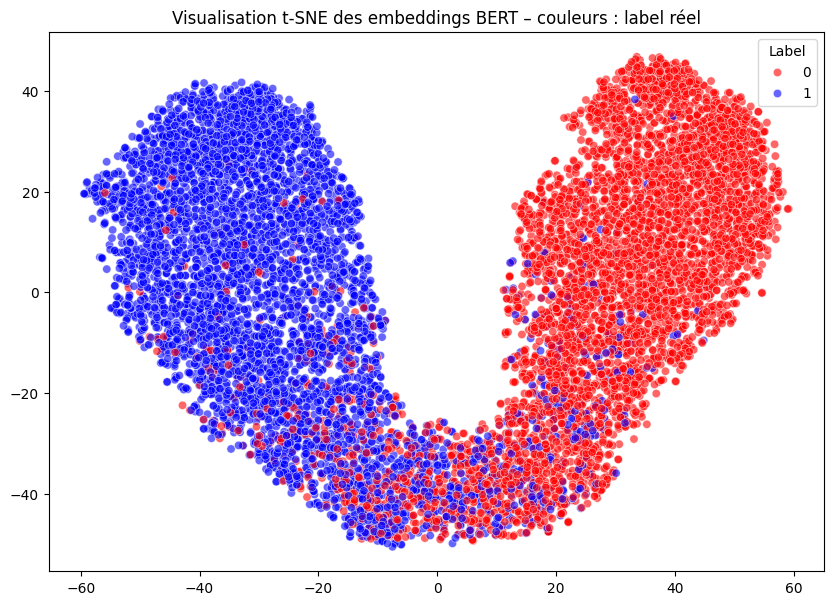

In [22]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1],
                hue=df_test["label"],
                palette={0: "red", 1: "blue"},
                alpha=0.6)
plt.title("Visualisation t-SNE des embeddings BERT – couleurs : label réel")
plt.legend(title="Label")
plt.show()

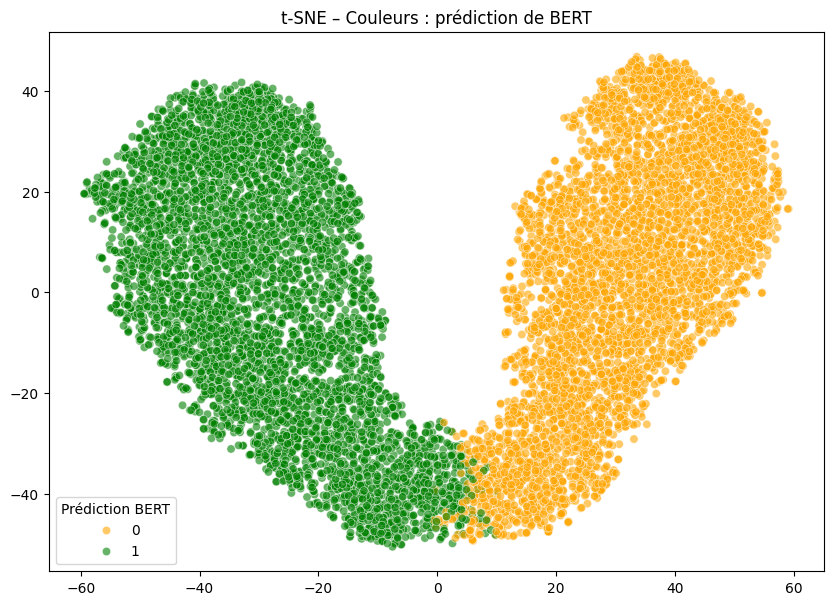

In [23]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1],
                hue=y_pred_bert,
                palette={0: "orange", 1: "green"},
                alpha=0.6)
plt.title("t-SNE – Couleurs : prédiction de BERT")
plt.legend(title="Prédiction BERT")
plt.show()

Les deux visualisations montrent la structure interne des représentations produites par DistilBERT, réduites ici en deux dimensions via t-SNE. Dans le premier graphique, les points sont colorés selon le label réel, et on observe une séparation nette entre les critiques positives et négatives, malgré une zone centrale de recouvrement où les deux classes se mélangent. Cela reflète la capacité du modèle à organiser les textes selon leur polarité dans l’espace latent.

Le second graphique colore les points selon la prédiction du modèle. La correspondance avec la première figure est très forte, ce qui indique que BERT s’appuie efficacement sur ces représentations pour classer les textes. Les erreurs se situent majoritairement dans la zone de transition, suggérant que ce sont les critiques les plus ambiguës qui posent problème. Cela confirme la robustesse du modèle et la qualité des embeddings appris.

In [23]:
config = DistilBertConfig.from_pretrained("distilbert-base-uncased", num_labels=2)
model = DistilBertWithER.from_pretrained("distilbert-base-uncased", config=config)

train_dataset = BERTDatasetWithER(dataset["train"])
eval_dataset = BERTDatasetWithER(dataset["test"])

training_args = TrainingArguments(
    output_dir="./results_with_er",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,     # ⬅️ version PyTorch compatible avec er_score
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()
results_with_er = trainer.evaluate()
print("📈 Résultats DistilBERT + ER score :", results_with_er)

Some weights of DistilBertWithER were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.377500,0.325235,0.873333,0.880126,0.835955,0.929226
2,0.207200,0.358035,0.889583,0.891349,0.878029,0.905079


📈 Résultats DistilBERT + ER score : {'eval_loss': 0.3580353856086731, 'eval_accuracy': 0.8895833333333333, 'eval_f1': 0.8913489134891349, 'eval_precision': 0.8780290791599353, 'eval_recall': 0.9050791007493755, 'eval_runtime': 9.4858, 'eval_samples_per_second': 253.011, 'eval_steps_per_second': 15.813, 'epoch': 2.0}


In [24]:
comparison = pd.DataFrame([
    {
        "Modèle": "DistilBERT",
        "Accuracy": results["eval_accuracy"],
        "F1": results["eval_f1"],
        "Precision": results["eval_precision"],
        "Recall": results["eval_recall"],
    },
    {
        "Modèle": "DistilBERT + ER",
        "Accuracy": results_with_er["eval_accuracy"],
        "F1": results_with_er["eval_f1"],
        "Precision": results_with_er["eval_precision"],
        "Recall": results_with_er["eval_recall"],
    }
])

comparison

,Modèle,Accuracy,F1,Precision,Recall
0,DistilBERT,0.907292,0.906611,0.904144,0.909091
1,DistilBERT + ER,0.889583,0.891349,0.878029,0.905079


L'ajout du score er_score comme feature parallèle dans DistilBERT ne permet pas ici d'améliorer les performances du modèle. On observe même une légère baisse de l’accuracy et du F1-score, respectivement de 90,7 % à 88,9 %, et de 0,906 à 0,891. Cette diminution s’explique probablement par le fait que BERT capture déjà implicitement l’information affective à travers ses représentations contextuelles. Ajouter un signal externe redondant, non appris, peut donc introduire du bruit ou déséquilibrer l’espace latent sans bénéfice direct. Ces résultats suggèrent que les modèles Transformers, lorsqu’ils sont fine-tunés, intègrent efficacement la polarité sans nécessiter de renfort lexical explicite.